<a href="https://colab.research.google.com/github/khanhvy31/humanactivity_wearablesensor/blob/main/Human_Activity_Classification_from_Wearable_Sensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EDA

In [ ]:
!pip3 install import-ipynb  -qqq

     |████████████████████████████████| 1.6 MB 4.9 MB/s 


### 1.1 MHEALTH DATASET



### Import Package

2) Activity set

The activity set is listed in the following:

L1: Standing still (1 min) 

L2: Sitting and relaxing (1 min) 

L3: Lying down (1 min) 

L4: Walking (1 min) 

L5: Climbing stairs (1 min) 

L6: Waist bends forward (20x) 

L7: Frontal elevation of arms (20x)

L8: Knees bending (crouching) (20x)

L9: Cycling (1 min)

L10: Jogging (1 min)

L11: Running (1 min)

L12: Jump front & back (20x)

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from os import listdir
from random import shuffle
from pickle import dump, load

import torch
import numpy as np
import import_ipynb
import torch.nn as nn
from tqdm import tqdm
from datetime import datetime
import torch.nn.functional as F

from random import shuffle
from google.colab import drive

from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

# from data_prep import MH_TrainValGenerator
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/CIS 4190 5190/Project/
from Model import modelV1, ConvNet1D, RNNModel

from Model import MLP1, MLP2, MLP3

import matplotlib.pyplot as plt

Mounted at /content/drive
/content/drive/Shareddrives/CIS 4190 5190/Project
importing Jupyter notebook from Copymodel.ipynb
importing Jupyter notebook from model.ipynb


In [ ]:
class Config():
  def __init__(self, sample_length, test_prop, batch_size, epochs, lr, device):
    self.sample_length = sample_length
    self.test_prop = test_prop
    self.batch_size = batch_size
    self.epochs = epochs
    self.lr = lr
    self.device = device
c = Config(16, 0.7, 32, 20, 3e-4, "cuda")

In [ ]:
class MH_TrainValGenerator:
  # Creates Train Val Sets for each User number
  def __init__(self, config):
    mhealth_files = self.getMHEALTHFiles()
    val_sets = self.getSets(mhealth_files)
    self.c = config
    self.get_folds(val_sets)

  def __getitem__(self, idx):
    return self.folds[idx]
  
  def __len__(self):
    return len(self.folds)
  
  def getMHEALTHFiles(self):
    "get list of mhealth file paths"
    data_path = "Data/"
    dataset_path = data_path + "MHEALTHDATASET/"
    return [dataset_path + filename for filename in listdir(dataset_path) if filename.endswith(".log")]
  
  def getSets(self, mhealth_files):
    'gets [[train], [val]] sets'
    val_sets = []
    for i in range(len(mhealth_files)):
      inter = mhealth_files.copy()
      val = inter.pop(i)
      val_sets.append([inter, val])
    return val_sets

  def readData(self, file_path):
    "Read MHEALTH .log file into dataframe"
    columns = ['accX', 'accY', 'accZ', 'ecs1', 'ecs2', 'acc_laX','acc_laY', 'acc_laZ', 'gyro_laX','gyro_laY','gyro_laZ', 'mm_laX','mm_laY','mm_laZ', 'acc_rlaX','acc_rlaY','acc_rlaZ', 'gyro_rlaX','gyro_rlaY', 'gyro_rlaZ', 'mm_rlaX','mm_rlaY','mm_rlaZ', 'Label']
    mh_df = pd.read_csv(file_path, names= columns, sep=r'\t', engine='python')
    return mh_df

  def combineFiles(self, data_paths):
    "combines all data files into one dataframe"
    dfs = [self.readData(path) for path in data_paths]
    # shifting indices to preserve continuity between sensor readings, and separating participant data
    shift = 0
    for i in range(len(dfs)):
      dfs[i].index = dfs[i].index + shift
      shift += dfs[i].shape[0] + 1
    df = pd.concat(dfs, axis=0)
    return df

  def getContiguousStartInds(self, mhealth_df):
    cont_start_inds = dict()
    for label in mhealth_df.Label.unique():
      activity = mhealth_df[mhealth_df["Label"] == label].sort_index()

      inds = activity.index.unique().tolist()

      cont = [inds[i] == inds[i-1] + 1 for i in range(1, len(inds))]

      start_inds = [inds[0]]
      end_inds = []
      for i in range(len(cont)):
        if not cont[i]:
          start_inds.append(inds[i+1])
          end_inds.append(inds[i])
      end_inds.append(inds[-1])

      cont_start_inds[label] = list(zip(start_inds, end_inds))
    return cont_start_inds

  def processData(self, mhealth_df):
    # dict with {activity_label: [sensor_start_0, sensor_start_1, ...]}
    cont_sensor_slices = self.getContiguousStartInds(mhealth_df)
    #@title Creating contiguous samples of length n, {label: [(start_0, end_0), (start_1, end_1)]}
    sample_slices = dict()

    for label in mhealth_df.Label.unique():
      sample_slices[label] = []
      slices = cont_sensor_slices[label]
      for data_slice in slices:
        start, end = data_slice
        for s in range(start, end - self.c.sample_length): # length of samples from config
          e = s + self.c.sample_length
          sample_slices[label].append((s, e))

    #@title Balancing dataset wrt classes
    min_num_samps = float("inf")
    labels = list(mhealth_df.Label.unique())
    labels.remove(0)
    for label in labels:
      min_num_samps = min(len(sample_slices[label]), min_num_samps)

    balanced_omega_slices = []
    for label in labels:
      shuffle(sample_slices[label])
      balanced_omega_slices += sample_slices[label][:min_num_samps]

    #@title Converting samples to numpy array (omega)
    omega = []
    for (s, e) in balanced_omega_slices:
      sample = np.expand_dims(mhealth_df.iloc[s:e].to_numpy(), 0)
      omega.append(sample)
    shuffle(omega)
    omega = np.vstack(omega)
    return omega

  def get_folds(self, val_sets):
    # pickle the folds file
    folds_folder = "MH_Pickled Folds/"
    if f"PICKLED_FOLDS_{self.c.sample_length}" not in listdir(folds_folder):
      self.folds = {i: [self.processData(self.combineFiles(x[0])), self.processData(self.combineFiles([x[1]]))] for i, x in enumerate(val_sets)}
      with open(f"{folds_folder}PICKLED_FOLDS_{self.c.sample_length}", "wb+") as f_:
        dump(self.folds, f_)
    else:
      with open(f"{folds_folder}PICKLED_FOLDS_{c.sample_length}", "rb") as f_:
        self.folds = load(f_)

##Load data

In [ ]:
if __name__ == "__main__":
  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/Shareddrives/CIS 4190 5190/Project/
  mh_trainval = MH_TrainValGenerator(c)
  # i = 0,  ..n -> kth fold 
  # mh_trainval[0][1][0,:,:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/Shareddrives/CIS 4190 5190/Project/'
/content/drive/Shareddrives/CIS 4190 5190/Project


## 1.2 HARdataset

## Load data

‘Biking’, ‘Sitting’, ‘Standing’, ‘Walking’, ‘Stair Up’ and ‘Stair down’.

In [ ]:
class HAR_TrainValGenerator:
  # Creates Train Val Sets for each User number
  def __init__(self, config):
    self.user_list = ["a","b","c","d","e","f","g","h","i"] #list(dataframe["User"].unique())
    
    #The activities are also labeles as string right now, -> convert them to label
    act_list = ["bike","sit","stand","walk","stairsup", "stairsdown"]
    self.action_to_label = dict(zip(act_list, range(len(act_list))))
    self.c = config
    # dictionary that contains data per user
    self.user_to_data_dict = dict()
    # users are labeled as alphabets -> convert to number
    self.num_to_user_dict = dict(zip(range(len(self.user_list)),self.user_list))

  def __getitem__(self,idx):
    if idx >= 9:
      return [0,0]
    user_to_data_dict = dict()
    #Due to RAM issues, load data whenever a pair of [train, val] is called
    user_to_data_dict = self.load_folds(user_to_data_dict)
    
    # create [train, val] pair by concatenating data
    shape_ = user_to_data_dict[self.num_to_user_dict[0]].shape
    train_df= np.zeros((0,self.c.sample_length, shape_[2]))
    for k in range(len(self.user_list)):
      if k != idx:
        train_df = np.concatenate([train_df, user_to_data_dict[self.num_to_user_dict[k]]])
    val_df = user_to_data_dict[self.num_to_user_dict[idx]]
    train_df = train_df.astype(float)
    val_df = val_df.astype(float)
    return [train_df, val_df]

    # shape_ = self.user_to_data_dict[self.num_to_user_dict[0]].shape
    # train_df= np.zeros((0,self.c.sample_length, shape_[2]))
    # for k in range(len(self.user_to_data_dict)):
    #   if k != idx:
    #     train_df = np.concatenate([train_df, self.user_to_data_dict[self.num_to_user_dict[k]]])
    # val_df = self.user_to_data_dict[self.num_to_user_dict[idx]]
    # return [train_df, val_df]
  
  def __len__(self):
    return len(self.user_list)
  
  def readHARData(self):
    # get individual files
    ph_gyro_df = pd.read_csv('./Data/activity_recognition_exp/Phones_gyroscope.csv')
    ph_acc_df = pd.read_csv('./Data/activity_recognition_exp/Phones_accelerometer.csv')
    wa_gyro_df = pd.read_csv('./Data/activity_recognition_exp/Watch_gyroscope.csv')
    wa_acc_df = pd.read_csv('./Data/activity_recognition_exp/Watch_accelerometer.csv')

    # merge phone dataset and watch dataset respectively
    rename_dict = lambda x: {"Arrival_Time":f"{x}_Arrival_Time","Creation_Time":f"{x}_Creation_Time", "x":f"{x}_x", "y":f"{x}_y", "z":f"{x}_z"}
    ph_acc_df = ph_acc_df.rename(columns=rename_dict("acc")).dropna(subset=["gt"])
    ph_gyro_df = ph_gyro_df.rename(columns=rename_dict("gyro")).dropna(subset=["gt"])
    wa_acc_df = wa_acc_df.rename(columns=rename_dict("acc")).dropna(subset=["gt"])
    wa_gyro_df = wa_gyro_df.rename(columns=rename_dict("gyro")).dropna(subset=["gt"])
    ph_merged_df = ph_acc_df.merge(ph_gyro_df, on = ["Index", "Model", "Device", "gt","User"]).sort_values(by = ["User","gt","Model", "Device","Index"])
    wa_merged_df = wa_acc_df.merge(wa_gyro_df, on = ["Index", "Model", "Device", "gt","User"]).sort_values(by = ["User","gt","Model", "Device","Index"])

    return ph_merged_df, wa_merged_df

  def load_folds(self, user_to_data_dict):
    # if one giant file exists, load it
    folds_folder = "HAR_Pickled_Folds/"
    if f"PICKLED_FOLDS_{self.c.sample_length}" in listdir(folds_folder):
      print("loading data from pickle file")
      with open(f"{folds_folder}PICKLED_FOLDS_{self.c.sample_length}", "rb") as f:
        user_to_data_dict = load(f)
        print(user_to_data_dict['a'].shape)
    # if not, pickle the data by user
    else: 
      # dataframe = None
      if not all([f"PICKLED_FOLDS_{self.c.sample_length}_{user}" in listdir(folds_folder) for user in self.user_list]):
        dataframe,_ = self.readHARData()
        dataframe['gt'] = dataframe['gt'].apply(lambda x: self.action_to_label[x]).astype(int)
      for user in self.user_list:
        if f"PICKLED_FOLDS_{self.c.sample_length}_{user}" not in listdir(folds_folder):  
          user_data = self.get_user_dict(dataframe, user)
          with open(f"{folds_folder}PICKLED_FOLDS_{self.c.sample_length}_{user}", "wb+") as f_:
            dump(user_data, f_)
            user_to_data_dict[user] = user_data
        else:
          with open(f"{folds_folder}PICKLED_FOLDS_{self.c.sample_length}_{user}", "rb") as f_:
            print(f"loading data from pickle file for user {user}")
            user_to_data_dict[user] = load(f_)
            print(f"user {user} shape : {user_to_data_dict[user].shape}")
      # balancing the data
      min_data_length = min([len(user_to_data_dict[user]) for user in self.user_list])
      for user in self.user_list:
        print(user_to_data_dict[user].shape)
        user_to_data_dict[user] = user_to_data_dict[user][:min_data_length,:,:]
        
      print("finished balancing the dataset by label")
    return user_to_data_dict

  def get_user_dict(self, dataframe, user):
    x_data = []
    user_df = dataframe[dataframe["User"] == user]
    seq_data_sample_length = [list(user_df.iloc[0][["Index", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "gt"]])]
    for i in tqdm(range(1,len(user_df))):
      if len(seq_data_sample_length) == self.c.sample_length:
          x_data.append(seq_data_sample_length)
          # y_data.append(k_df.iloc[i-1][["gt"]])
          seq_data_sample_length = list()
      if all(user_df.iloc[i][["gt","Model"]] == user_df.iloc[i-1][["gt","Model"]]) and ("_1" in user_df.iloc[i]["Device"]):
          seq_data_sample_length.append(list(user_df.iloc[i][["Index", "acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z", "gt"]]))
      else:
        seq_data_sample_length = []
        seq_data_sample_length.append(list(user_df.iloc[i][["Index", "acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z", "gt"]]))
    x = np.array(x_data)
    # y = np.array(y_data)
    return x


#1.2 Model

In [ ]:
folds_folder = "HAR_Pickled_Folds/"
user_to_data_dict = dict()
total_np= np.zeros((0,16, 7))
for user in ["a","b","c","d","e","f","g","h","i"]:
  with open(f"{folds_folder}PICKLED_FOLDS_{16}_{user}", "rb") as f_:
    print(f"loading data from pickle file for user {user}")
    user_to_data_dict[user] = load(f_)[:,:,1:]
    # user_to_data_dict[user] = user_to_data_dict[user]
    print(f"user {user} shape : {user_to_data_dict[user].shape}")



    break
# with open(f"{folds_folder}PICKLED_FOLDS_{16}", "wb+") as f_:
#   dump(user_to_data_dict, f_)
# print(user_to_data_dict['a'].shape) 

loading data from pickle file for user a
user a shape : (28848, 16, 7)


##cross joined datasets

In [ ]:
#### FUNCTIONS FOR GENERATING CROSS-JOINED DATASET

import numpy as np 
import pandas as pd 
from torch.utils.data import DataLoader


# given np arrays mh_data and har_data
# and mapping 'mapping' for classes in har_data to classes in mh_data
def crossjoinDatasets(mh_data: np.array, har_data: np.array, har_mh_mapping: dict) -> np.array:
    # dataframes for each dataset
    new_mh_data = []
    for row in mh_data:
      r_class = row[:, -1][0]
      r = row[:, :-1]
      r = np.append(r, r_class)
      new_mh_data.append(r)
    mh_data = np.array(new_mh_data)
    mh_data = pd.DataFrame(mh_data).rename({368: "class"}, axis=1)
    mh_df = pd.DataFrame(mh_data)

    new_har_data = []
    for row in har_data:
      r_class = row[:, -1][0]
      r = row[:, :-1]
      r = np.append(r, r_class)
      new_har_data.append(r)
    har_data = np.array(new_har_data)
    har_data = pd.DataFrame(har_data).rename({96: "class"}, axis=1)
    har_df = pd.DataFrame(har_data)

    # remove non-present class in har
    har_df = har_df[har_df['class'] != 5]

    # rename labels in har to labels in mh
    har_df['class'] = har_df['class'].apply(lambda x: har_mh_mapping[x])

    # list of classes in mapped har
    valid_classes = set(har_df['class'].unique()).intersection(set(mh_df['class']))

    # drop rows in datasets where row[class] doesn't exist in class intersection
    har_df = har_df[har_df["class"].apply(lambda x: x in valid_classes)]
    mh_df = mh_df[mh_df["class"].apply(lambda x: x in valid_classes)]

    # ASSUMING BALANCED DATASETS
    omega = pd.DataFrame() # new dataset with pairs of matching-class rows
    for c in valid_classes:
        mh_class_members = mh_df[mh_df["class"] == c][mh_df.columns.tolist()[:-1]] # all cols except the last class
        har_class_members = har_df[har_df["class"] == c]

        # SAMPLE TO REDUCE MEMORY USAGE
        mh_class_members = mh_class_members.sample(300)
        har_class_members = har_class_members.sample(300)

        joined_df = mh_class_members.merge(har_class_members, how="cross")
        omega = pd.concat([omega, joined_df])

    return omega.to_numpy()


def crossJoin(mh, har):
    # mh and har datasets
    mh_data = mh.copy()
    har_data = har.copy()

    # mapping between class in har and class in mh
    har_mh_mapping = {0: 9,
                      1: 2,
                      2: 1,
                      3: 4,
                      4: 5
                    }

    # numpy array with size (16, 30)
    new_dataset_arr = crossjoinDatasets(mh_data, har_data, har_mh_mapping)
    np.random.shuffle(new_dataset_arr)
    # return new_dataset_arr

    # train and val loaders
    split_ind = round(len(new_dataset_arr) * c.test_prop)
    # trainloader = DataLoader(new_dataset_arr[:split_ind], c.batch_size, shuffle=True)
    # valloader = DataLoader(new_dataset_arr[split_ind:], c.batch_size, shuffle=True)
    return DataLoader(new_dataset_arr[split_ind:], c.batch_size, shuffle=True)

In [ ]:
#### decoders to ensure models do not lose information when generating the latent space vectors

class Decoder0(nn.Module):
  def __init__(self):
    super().__init__()
    self.dec0 = nn.Sequential(
        nn.Linear(10, 20),
        nn.ReLU(),
        nn.Linear(20, 24),
        nn.ReLU()
    )
    self.dec1 = nn.Sequential(
        nn.ConvTranspose1d(3, 10, 5),
        nn.ReLU(),
        nn.ConvTranspose1d(10, 20, 5),
        nn.ReLU(),
        nn.ConvTranspose1d(20, 10, 5),
        nn.ReLU(),
        nn.ConvTranspose1d(10, 16, 5),
        nn.Flatten(start_dim=1),
        nn.ReLU(),
        nn.Linear(384, 368)
    )

  def forward(self, x):
    b_size = x.shape[0]
    x = self.dec0(x)
    x = x.reshape((x.shape[0], 3, -1))
    x = self.dec1(x)
    x = x.reshape((b_size, 16, 23))
    return x


class Decoder1(nn.Module):
  def __init__(self):
    super().__init__()
    self.dec0 = nn.Sequential(
        nn.Linear(10, 40),
        nn.ReLU(),
        nn.Linear(40, 189),
        nn.ReLU()
    )
    self.dec1 = nn.Sequential(
        nn.ConvTranspose1d(3, 10, 5),
        nn.ReLU(),
        nn.ConvTranspose1d(10, 5, 5),
        nn.ReLU(),
        nn.ConvTranspose1d(5, 1, 5),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.ReLU(),
        nn.Linear(75, 96)
    )

  def forward(self, x):
    b_size = x.shape[0]
    x = self.dec0(x)
    x = x.reshape((x.shape[0], 3, -1))
    x = self.dec1(x)
    x = x.reshape((b_size, 16, 6))
    return x


# class Classifier(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.classi = nn.Sequential(
#         nn.Linear(6, 6),
#         nn.ReLU(),
#         nn.Linear(6, 6),
#         nn.ReLU(),
#         nn.Linear(6, 6)
#     )

#   def forward(self, x):
#     x = self.classi(x)
#     return x


class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.classi = nn.Sequential(
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 6)
    )

  def forward(self, x):
    x = self.classi(x)
    return x


# decoder = Decoder0()

# tens = torch.randn((32, 6))

# y = decoder(tens).reshape((32, 16, 23))

# y.shape

In [ ]:
loss_by_class = {}

def trainOnJointDataset(model0, model1, opti, loss_fn, trainloader, valloader, c):
  global loss_by_class
  model0.train()
  model1.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      batch_size = batch.shape[0]
      x0 = batch[:, :368].reshape((batch_size, 16, 23)).float()
      x1 = batch[:, 368:-1].reshape((batch_size, 16, 6)).float()
      y = batch[:, -1]

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model0(x0)
      y1 = model1(x1)

      y0 = F.log_softmax(y0, dim=1)
      y1 = F.log_softmax(y1, dim=1)

      # calculate loss and backprop
      loss = loss_fn(y0, y1)
      loss.backward()
      if i % 100 == 0:
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"{y0[0].tolist()}")
        print(f"{y1[0].tolist()}")
        print()


      for y_i in y:
        y_class = y_i.item()
        if y_class in loss_by_class:
          loss_by_class[y_class].append(loss.item())
        else:
          loss_by_class[y_class] = []

      # update weights from loss
      opti.step()


def trainOnJointDataset2(model0, model1, model01, model11, opti, loss_fn, trainloader, valloader, c):
  global loss_by_class
  model0.train()
  model1.train()
  model01.train()
  model11.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      batch_size = batch.shape[0]
      x0 = batch[:, :368].reshape((batch_size, 16, 23)).float()
      x1 = batch[:, 368:-1].reshape((batch_size, 16, 6)).float()
      y = batch[:, -1]

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model0(x0)
      y1 = model1(x1)

      y01 = model01(y0)
      y11 = model11(y1)

      y0 = F.log_softmax(y0, -1)
      # print(torch.sum(y0, axis=1))
      y1 = F.log_softmax(y1, -1)

      # calculate loss and backprop

      kl = loss_fn(y0, y1)
      l0 =  F.mse_loss(y01, x0) 
      l1 =  F.mse_loss(y11, x1) 
      loss = kl + l0 + l1
      loss.backward()
      if i % 100 == 0:
        print(f"Epoch: {epoch}, Batch Number: {i}, Total Loss: {loss.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, KL Loss: {kl.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, MH MSE Loss: {l0.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, HAR MSE Loss: {l1.item()}")
        print(f"{y0[0].tolist()}")
        print(f"{y1[0].tolist()}")
        print()


      for y_i in y:
        y_class = y_i.item()
        if y_class in loss_by_class:
          loss_by_class[y_class].append(loss.item())
        else:
          loss_by_class[y_class] = []

      # update weights from loss
      opti.step()


def trainOnJointDataset3(model0, model1, model01, model11, classi, opti, loss_fn, trainloader, valloader, c, joint_class_acc):
  global loss_by_class
  model0.train()
  model1.train()
  model01.train()
  model11.train()
  classi.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      batch_size = batch.shape[0]
      x0 = batch[:, :368].reshape((batch_size, 16, 23)).float()
      x1 = batch[:, 368:-1].reshape((batch_size, 16, 6)).float()
      y = batch[:, -1]

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model0(x0)
      y1 = model1(x1)

      y01 = model01(y0)
      y11 = model11(y1)

      y_pred0 = classi(y0)
      y_pred1 = classi(y1)

      y0 = F.log_softmax(y0, -1)
      # y1 = F.log_softmax(y1, -1)
      y1 = F.softmax(y1, -1)

      # print(y0[:2])
      # print(y1[:2])

      # calculate loss and backprop

      kl = loss_fn(y0, y1)
      # l0 =  F.mse_loss(y01, x0) 
      # l1 =  F.mse_loss(y11, x1) 
      class_loss0 = F.cross_entropy(y_pred0, y)
      class_loss1 = F.cross_entropy(y_pred1, y)
      # loss = kl + l0 + l1 + class_loss0 + class_loss1
      # loss = kl + class_loss0 + class_loss1
      loss = class_loss0 + class_loss1

      loss.backward()

      if i % 100 == 0:
        print(f"Epoch: {epoch}, Batch Number: {i}, Total Loss: {loss.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, KL Loss: {kl.item()}")
        # print(f"Epoch: {epoch}, Batch Number: {i}, MH MSE Loss: {l0.item()}")
        # print(f"Epoch: {epoch}, Batch Number: {i}, HAR MSE Loss: {l1.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, MH Class Loss: {class_loss0.item()}")
        print(f"Epoch: {epoch}, Batch Number: {i}, HAR Class Loss: {class_loss1.item()}")

        acc = (sum(torch.argmax(y_pred0, dim=1) == torch.argmax(y_pred1, dim=1)) / y.shape[0]).item()

        joint_class_acc.append((epoch, i, acc))

        print(f"{y0[0].tolist()}")
        print(f"{y1[0].tolist()}")
        print()


      for y_i in y:
        y_class = y_i.item()
        if y_class in loss_by_class:
          loss_by_class[y_class].append(loss.item())
        else:
          loss_by_class[y_class] = []

      # update weights from loss
      opti.step()





def trainOnHARDataset(model1, model2, opti, loss_fn, trainloader, valloader, c):
  model1.eval()
  model2.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      batch_size = batch.shape[0]
      x0 = batch[:, :368].reshape((batch_size, 16, 23)).float()
      x1 = batch[:, 368:-1].reshape((batch_size, 16, 6)).float()
      y = batch[:, -1].long()

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

       

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model1(x1)
      y1 = model2(y0)

      # calculate loss and backprop
      loss = loss_fn(y1, y)
      loss.backward()
      if i % 100 == 0:
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"acc: {(sum(torch.argmax(y1, dim=1) == y) / y.shape[0]).item()}")
        print()

      # update weights from loss
      opti.step()


In [ ]:
toggle = True

if toggle:
  mh_fold = 0
  har_fold = "a"

  ##################################### selecting folds
  # mh trainset and valset
  mh_trainset, mh_valset = mh_trainval[mh_fold]

  # har trainset and valset
  d_ = user_to_data_dict[har_fold]
  np.random.shuffle(d_)
  split_ind = round(d_.shape[0] * c.test_prop)
  har_trainset, har_valset = d_[:split_ind], d_[split_ind:]



  ##################################### balancing har
  def findClassFreqHAR(d):
    labels = {}
    for row in d:
      label = row[0, -1]
      if label in labels:
        labels[label] += 1
      else:
        labels[label] = 0
    return labels

  labels = findClassFreqHAR(d_)

  classes = set(d_[:, 0, -1])

  class_cap = min(labels.values())
  balanced_d_ = []
  for class_ in classes:
    filtered_samples = d_[d_[:, 0, -1] == class_]
    selected_samples = filtered_samples[:class_cap] # dataset is already shuffled
    balanced_d_.append(selected_samples)

  balanced_d_ = np.vstack(balanced_d_)
  labels = findClassFreqHAR(balanced_d_)



  ##################################### creating dataloaders
  # cross joined train and val dataloaders
  trainloader = crossJoin(mh_trainset, har_trainset)
  valloader = crossJoin(mh_valset, har_valset)


c.device = "cpu"

##################################### starting training
# create models and optimizers
model0 = MLP1(c).to(c.device)

model1 = MLP2(c).to(c.device)

model2 = MLP3(c).to(c.device)

model01 = Decoder0().to(c.device)
model11 = Decoder1().to(c.device)

classi = Classifier().to(c.device)



opti = torch.optim.Adam([{"params": model0.parameters(), "params": model1.parameters(), "params": model01.parameters(), "params": model11.parameters(), "params": classi.parameters()}], lr=c.lr)


# loss function
# loss_fn0 = nn.KLDivLoss(reduction="batchmean", log_target=True)
loss_fn0 = nn.KLDivLoss(reduction="batchmean", log_target=False)
loss_fn2 = nn.CrossEntropyLoss()

# start training
trainOnJointDataset(model0, model1, opti, loss_fn0, trainloader, valloader, c)
trainOnJointDataset2(model0, model1, model01, model11, opti, loss_fn2, trainloader, valloader, c)

In [ ]:
joint_class_acc = []

trainOnJointDataset3(model0, model1, model01, model11, classi, opti, loss_fn2, trainloader, valloader, c, joint_class_acc)

Streaming output truncated to the last 5000 lines.
[0.12195674329996109, 0.10420101881027222, 0.09281773865222931, 0.09223676472902298, 0.11370648443698883, 0.10279178619384766, 0.09379152953624725, 0.0756649374961853, 0.10536742210388184, 0.09746566414833069]

Epoch: 7, Batch Number: 3300, Total Loss: 2.2311151027679443
Epoch: 7, Batch Number: 3300, KL Loss: 2.3400068283081055
Epoch: 7, Batch Number: 3300, MH Class Loss: 0.9085323810577393
Epoch: 7, Batch Number: 3300, HAR Class Loss: 1.322582721710205
[-2.566850185394287, -2.4727256298065186, -2.345156192779541, -2.4103682041168213, -2.582496166229248, -2.235491991043091, -1.9102120399475098, -2.4108848571777344, -1.8628513813018799, -2.554705858230591]
[0.12773464620113373, 0.10367158055305481, 0.08918926864862442, 0.0916822999715805, 0.11363859474658966, 0.10373695194721222, 0.09542986005544662, 0.07457650452852249, 0.10349734127521515, 0.09684289991855621]

Epoch: 7, Batch Number: 3400, Total Loss: 2.1874189376831055
Epoch: 7, Bat

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'MH & HAR Dataset Discrimination Accuracy')

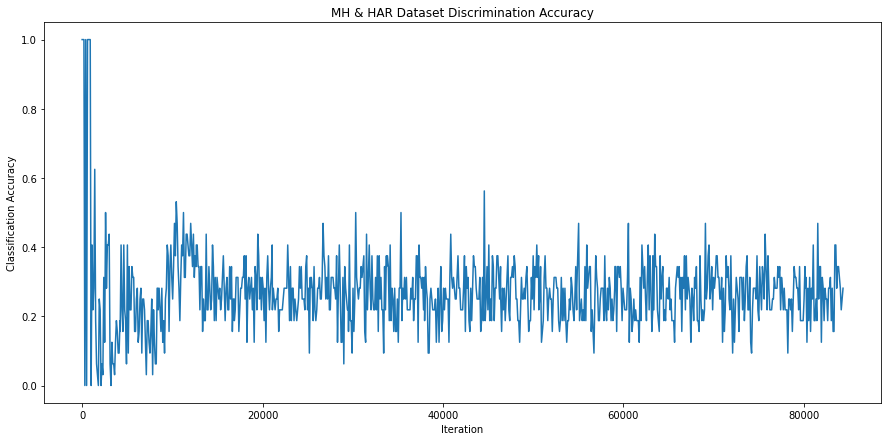

In [ ]:
epoch_size = 4219

xs = []
ys = []
for (e, i, l) in joint_class_acc:
  if e < 20:
    x = e*epoch_size + i
    y = l
    xs.append(x)
    ys.append(y)


plt.figure(figsize=(15, 7))
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.title("MH & HAR Dataset Discrimination Accuracy")

In [ ]:
har_mh_mapping = {0: 9,
                  1: 2,
                  2: 1,
                  3: 4,
                  4: 5
                }


new_har_data = []
for row in har_trainset:
  r_class = row[:, -1][0]
  r = row[:, :-1]
  r = np.append(r, r_class)
  new_har_data.append(r)
har_data = np.array(new_har_data)
har_data = pd.DataFrame(har_data).rename({96: "class"}, axis=1)
har_df = pd.DataFrame(har_data)

# remove non-present class in har
har_df = har_df[har_df['class'] != 5]

# rename labels in har to labels in mh
har_df['class'] = har_df['class'].apply(lambda x: har_mh_mapping[x])

valid_classes = set(har_mh_mapping.values())

new_mh_data = []
for row in mh_trainset:
  r_class = row[:, -1][0]
  r = row[:, :-1]
  r = np.append(r, r_class)
  new_mh_data.append(r)
mh_data = np.array(new_mh_data)
mh_data = pd.DataFrame(mh_data).rename({368: "class"}, axis=1)
mh_df = pd.DataFrame(mh_data)
mh_df = mh_df[mh_df["class"].apply(lambda x: x in valid_classes)]

In [ ]:
harset = har_df.to_numpy()
mhset = mh_df.to_numpy()

In [ ]:
def trainClassifierOnMHDataset(model1, model2, opti, loss_fn, trainloader, valloader, c, mh_class_acc):
  model1.eval()
  for param in model1.parameters():
      param.requires_grad = False
  model2.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      bsize = batch.shape[0]
      x0 = batch[:, :-1].reshape((bsize, 16, 23)).float()
      y = batch[:, -1].long()

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model1(x0)
      y1 = model2(y0)

      # calculate loss and backprop
      loss = loss_fn(y1, y)
      loss.backward()
      if i % 100 == 0:
        acc = (sum(torch.argmax(y1, dim=1) == y) / y.shape[0]).item()
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"acc: {acc}")
        print()
        mh_class_acc.append((epoch, i, acc))

      # update weights from loss
      opti.step()


def trainClassifierOnHARDataset(model1, model2, opti, loss_fn, trainloader, valloader, c, har_class_acc):
  model1.eval()
  for param in model1.parameters():
      param.requires_grad = False
  model2.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      bsize = batch.shape[0]
      x0 = batch[:, :-1].float()
      y = batch[:, -1].long()

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model1(x0)
      y1 = model2(y0)

      # calculate loss and backprop
      loss = loss_fn(y1, y)
      loss.backward()
      if i % 100 == 0:
        acc = (sum(torch.argmax(y1, dim=1) == y) / y.shape[0]).item()
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"acc: {acc}")
        print()
        har_class_acc.append((epoch, i, acc))

      # update weights from loss
      opti.step()



opti2 = torch.optim.Adam(model2.parameters(), lr=c.lr)

mhtrainloader = DataLoader(mhset, batch_size=c.batch_size, shuffle=True)
hartrainloader = DataLoader(harset, batch_size=c.batch_size, shuffle=True)

model2 = MLP3(c).to(c.device)


mh_class_acc = []
har_class_acc = []
eps = c.epochs
c.epochs = eps*3
trainClassifierOnMHDataset(model0, model2, opti2, loss_fn2, mhtrainloader, valloader, c, mh_class_acc)
c.epochs = eps*8
trainClassifierOnHARDataset(model1, model2, opti2, loss_fn2, hartrainloader, valloader, c, har_class_acc)

Text(0.5, 1.0, 'MH Classification Accuracy')

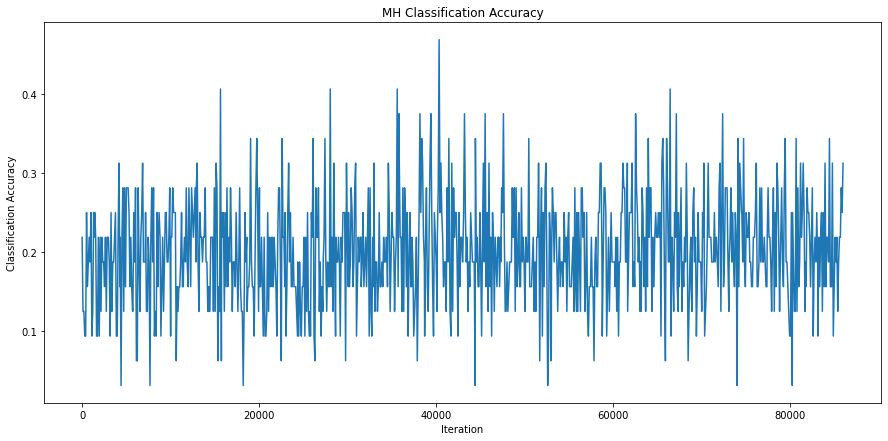

In [ ]:
epoch_size = len(mhtrainloader)

xs = []
ys = []
for (e, i, l) in mh_class_acc:
  x = e*epoch_size + i
  y = l
  xs.append(x)
  ys.append(y)


plt.figure(figsize=(15, 7))
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.title("MH Classification Accuracy")

Text(0.5, 1.0, 'HAR Classification Accuracy')

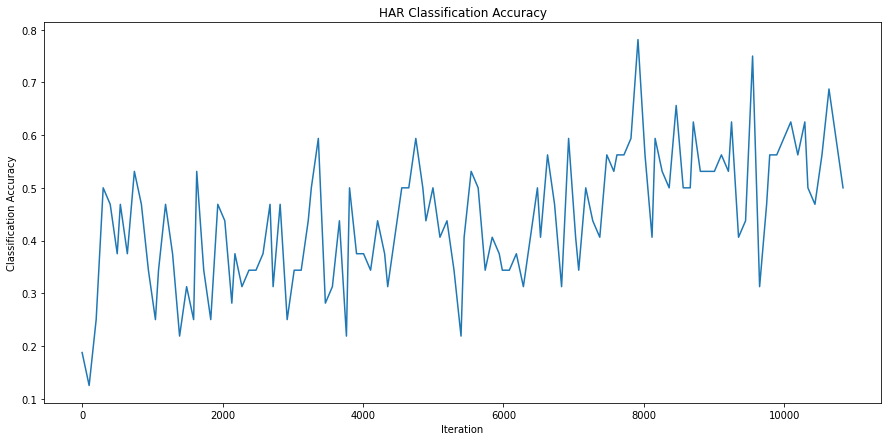

In [ ]:
epoch_size = len(hartrainloader)

xs = []
ys = []
for (e, i, l) in har_class_acc:
  x = e*epoch_size + i
  y = l
  xs.append(x)
  ys.append(y)

plt.figure(figsize=(15, 7))
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.title("HAR Classification Accuracy")

In [ ]:
c.lr = 3e-4

In [ ]:
class MHCLASSIFIER(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(368, 80),
        nn.ReLU(),
        nn.Linear(80, 80),
        nn.ReLU(),
        nn.Linear(80, 80),
        nn.ReLU(),
        nn.Linear(80, 20),
        nn.ReLU(),
        nn.Linear(20, 6)
    )

  def forward(self, x):
    x = self.layers(x)
    return x


class HARCLASSIFIER(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(96, 40),
        nn.ReLU(),
        nn.Linear(40, 40),
        nn.ReLU(),
        nn.Linear(40, 40),
        nn.ReLU(),
        nn.Linear(40, 20),
        nn.ReLU(),
        nn.Linear(20, 6)
    )

  def forward(self, x):
    x = self.layers(x)
    return x


def trainClassifierOnMHDataset(model, opti, loss_fn, trainloader, valloader, c, mh_class_acc):
  model.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      bsize = batch.shape[0]
      x0 = batch[:, :-1].reshape((bsize, 16, 23)).float()
      y = batch[:, -1].long()

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model(x0)

      # calculate loss and backprop
      loss = loss_fn(y0, y)
      loss.backward()
      if i % 100 == 0:
        acc = (sum(torch.argmax(y0, dim=1) == y) / y.shape[0]).item()
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"acc: {acc}")
        print()
        mh_class_acc.append((epoch, i, acc))

      # update weights from loss
      opti.step()


def trainClassifierOnHARDataset(model, opti, loss_fn, trainloader, valloader, c, har_class_acc):
  model.train()

  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch = batch.to(c.device)
      bsize = batch.shape[0]
      x0 = batch[:, :-1].float()
      y = batch[:, -1].long()

      mapping = {1: 0, 2: 1, 4: 3, 5: 4, 9: 5}
      y = y.apply_(lambda x: mapping[x]).long()

      # zero out gradients
      opti.zero_grad()

      # compute predictions
      y0 = model(x0)

      # calculate loss and backprop
      loss = loss_fn(y0, y)
      loss.backward()
      if i % 100 == 0:
        acc = (sum(torch.argmax(y0, dim=1) == y) / y.shape[0]).item()
        print(f"Epoch: {epoch}, Batch Number: {i}, Loss: {loss.item()}")
        print(f"acc: {acc}")
        print()
        har_class_acc.append((epoch, i, acc))

      # update weights from loss
      opti.step()



# mhtrainloader = DataLoader(mhset, batch_size=c.batch_size, shuffle=True)
# hartrainloader = DataLoader(harset, batch_size=c.batch_size, shuffle=True)

mhclassifier = MHCLASSIFIER().to(c.device)
mhopti = torch.optim.Adam(mhclassifier.parameters())

harclassifier = HARCLASSIFIER().to(c.device)
haropti = torch.optim.Adam(harclassifier.parameters())


mh_class_acc = []
har_class_acc = []
c.epochs = 40
trainClassifierOnHARDataset(harclassifier, haropti, loss_fn2, hartrainloader, valloader, c, har_class_acc)
c.epochs = 40
trainClassifierOnMHDataset(mhclassifier, mhopti, loss_fn2, mhtrainloader, valloader, c, mh_class_acc)

Epoch: 0, Batch Number: 0, Loss: 1.8816848993301392
acc: 0.125

Epoch: 0, Batch Number: 100, Loss: 0.9749867916107178
acc: 0.625

Epoch: 0, Batch Number: 200, Loss: 0.7063321471214294
acc: 0.6875

Epoch: 0, Batch Number: 300, Loss: 0.5416797399520874
acc: 0.875

Epoch: 0, Batch Number: 400, Loss: 0.41901323199272156
acc: 0.90625

Epoch: 0, Batch Number: 500, Loss: 0.3968566060066223
acc: 0.875

Epoch: 1, Batch Number: 0, Loss: 0.20690421760082245
acc: 0.9375

Epoch: 1, Batch Number: 100, Loss: 0.2991003394126892
acc: 0.875

Epoch: 1, Batch Number: 200, Loss: 0.4560733139514923
acc: 0.9375

Epoch: 1, Batch Number: 300, Loss: 0.25562313199043274
acc: 0.9375

Epoch: 1, Batch Number: 400, Loss: 0.09780123829841614
acc: 0.96875

Epoch: 1, Batch Number: 500, Loss: 0.21278806030750275
acc: 0.875

Epoch: 2, Batch Number: 0, Loss: 0.2933482527732849
acc: 0.875

Epoch: 2, Batch Number: 100, Loss: 0.3518252968788147
acc: 0.8125

Epoch: 2, Batch Number: 200, Loss: 0.23651443421840668
acc: 0.9375



Text(0.5, 1.0, 'MH Classification Accuracy')

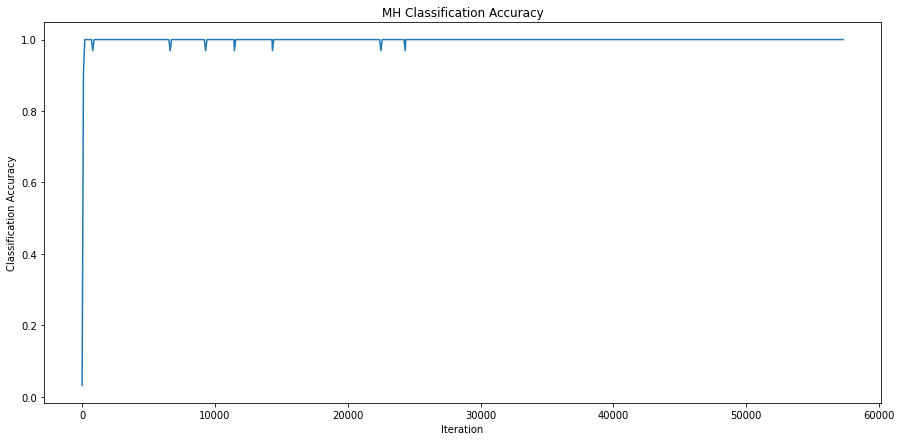

In [ ]:
epoch_size = len(mhtrainloader)

xs = []
ys = []
for (e, i, l) in mh_class_acc:
  x = e*epoch_size + i
  y = l
  xs.append(x)
  ys.append(y)


plt.figure(figsize=(15, 7))
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.title("MH Classification Accuracy")

Text(0.5, 1.0, 'HAR Classification Accuracy')

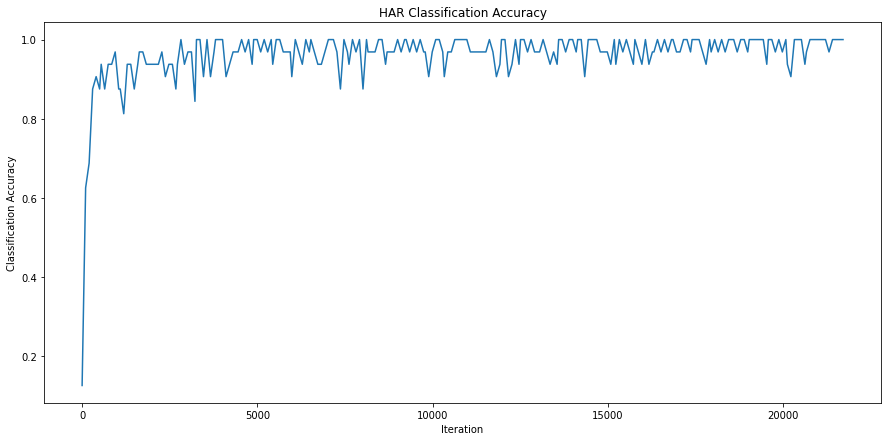

In [ ]:
epoch_size = len(hartrainloader)

xs = []
ys = []
for (e, i, l) in har_class_acc:
  x = e*epoch_size + i
  y = l
  xs.append(x)
  ys.append(y)


plt.figure(figsize=(15, 7))
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.title("HAR Classification Accuracy")